In [159]:
%matplotlib inline

In [160]:
%run ~/src/starry/notebooks/notebook_setup.py

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import starry
from starry_process import SP

starry.config.lazy = False
np.random.seed(0)

In [162]:
# Degree of the expansion
ydeg = 15

# Parameters of the beta distribution in cos(lat)
# This combination gives an *approximately*
# uniform distribution of spots over the sphere
alpha = 2
beta = 0.5

# Log spot size distribution
ln_sigma_mu = -3
ln_sigma_sigma = 0

# Log spot amplitude distribution
ln_amp_mu = -2.3
ln_amp_sigma = 0

# Sign of the spot amplitude (1 = positive)
sign = 1

# Instantiate the starry process
sp = SP(
    ydeg,
    alpha=alpha,
    beta=beta,
    ln_sigma_mu=ln_sigma_mu,
    ln_sigma_sigma=ln_sigma_sigma,
    ln_amp_mu=ln_amp_mu,
    ln_amp_sigma=ln_amp_sigma,
    sign=sign,
)

# Get the mean and covariance
# of the starry process
mu = sp.mu_y
cov = sp.cov_y

Pre-computing some matrices... Done.
Compiling `X`... Done.


Pre-computing some matrices... Done.
Compiling `expand_spot`... Done.
Compiling `render`... Done.


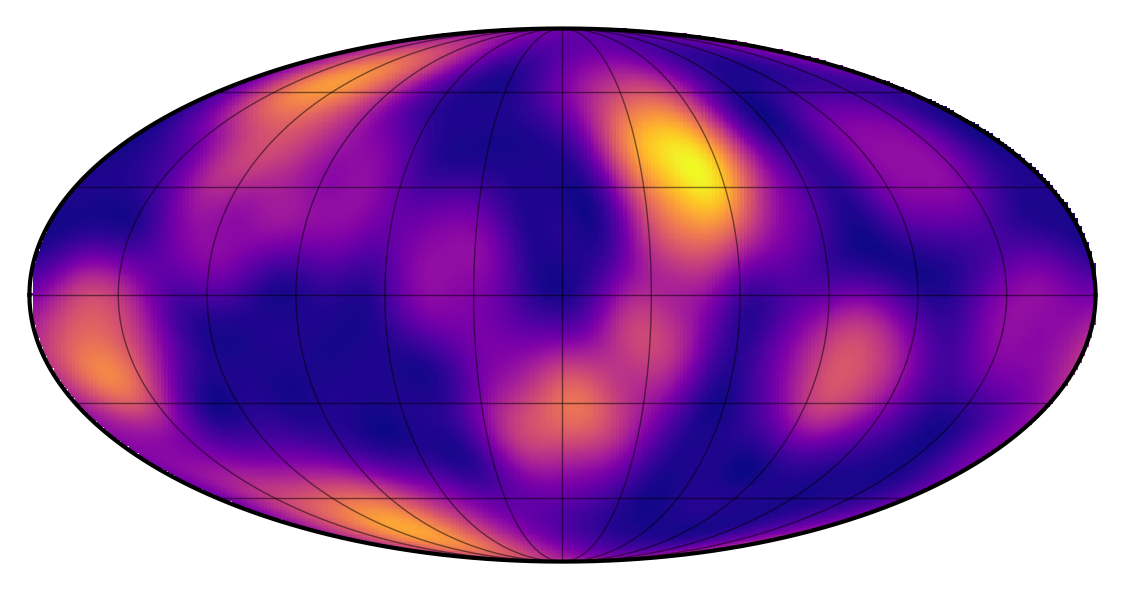

In [163]:
map = starry.Map(ydeg)
map.inc = 60
for i in range(25):
    map.add_spot(
        amp=np.exp(ln_amp_mu + ln_amp_sigma * np.random.randn()),
        sigma=np.exp(ln_sigma_mu + ln_sigma_sigma * np.random.randn()),
        lat=180 / np.pi * np.arccos(2 * np.random.random() - 1) - 90,
        lon=360 * np.random.random(),
        relative=False,
    )
map.amp = 1
y0 = np.array(map.y)
map.show(projection="moll")

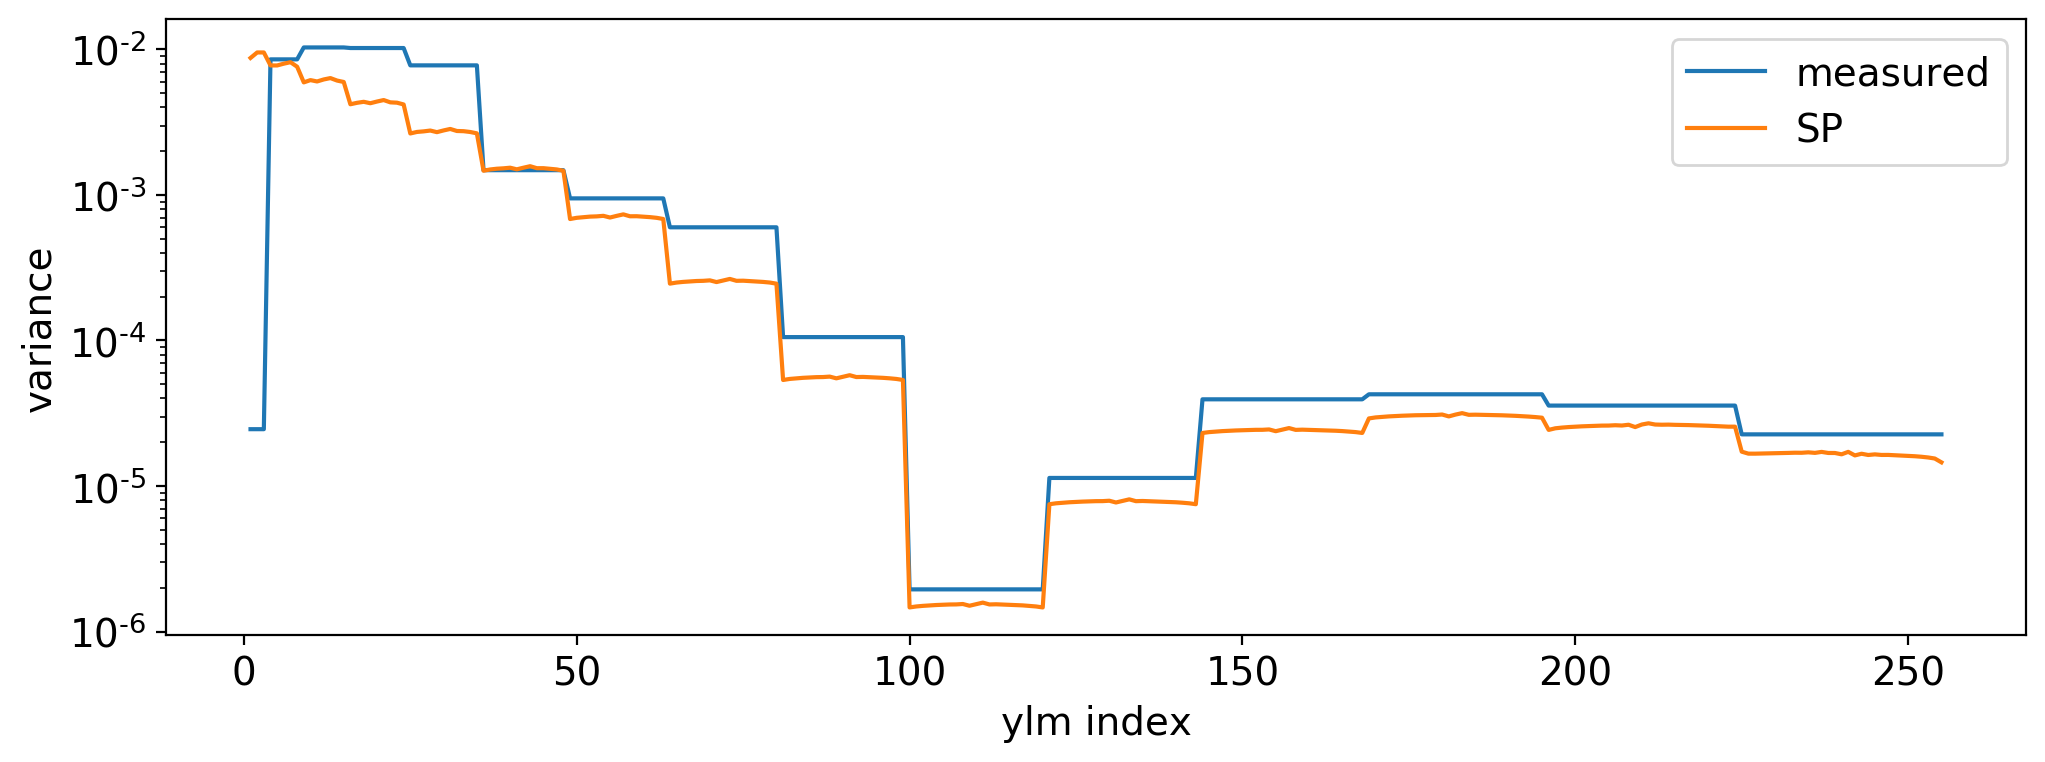

In [164]:
# Plot the starry process versus the empirical power spectrum
n = np.arange((ydeg + 1) ** 2)
l = np.concatenate([l * np.ones(2 * l + 1, dtype=int) for l in range(ydeg + 1)])
var = np.array([np.var(map[l_i, :]) for l_i in l])
var[0] = 1e-10
plt.plot(n[1:], var[1:], label="measured")
plt.plot(n[1:], np.diag(cov)[1:], label="SP")
plt.xlabel("ylm index")
plt.ylabel("variance")
plt.legend()
plt.yscale("log");

Compiling `flux`... Done.


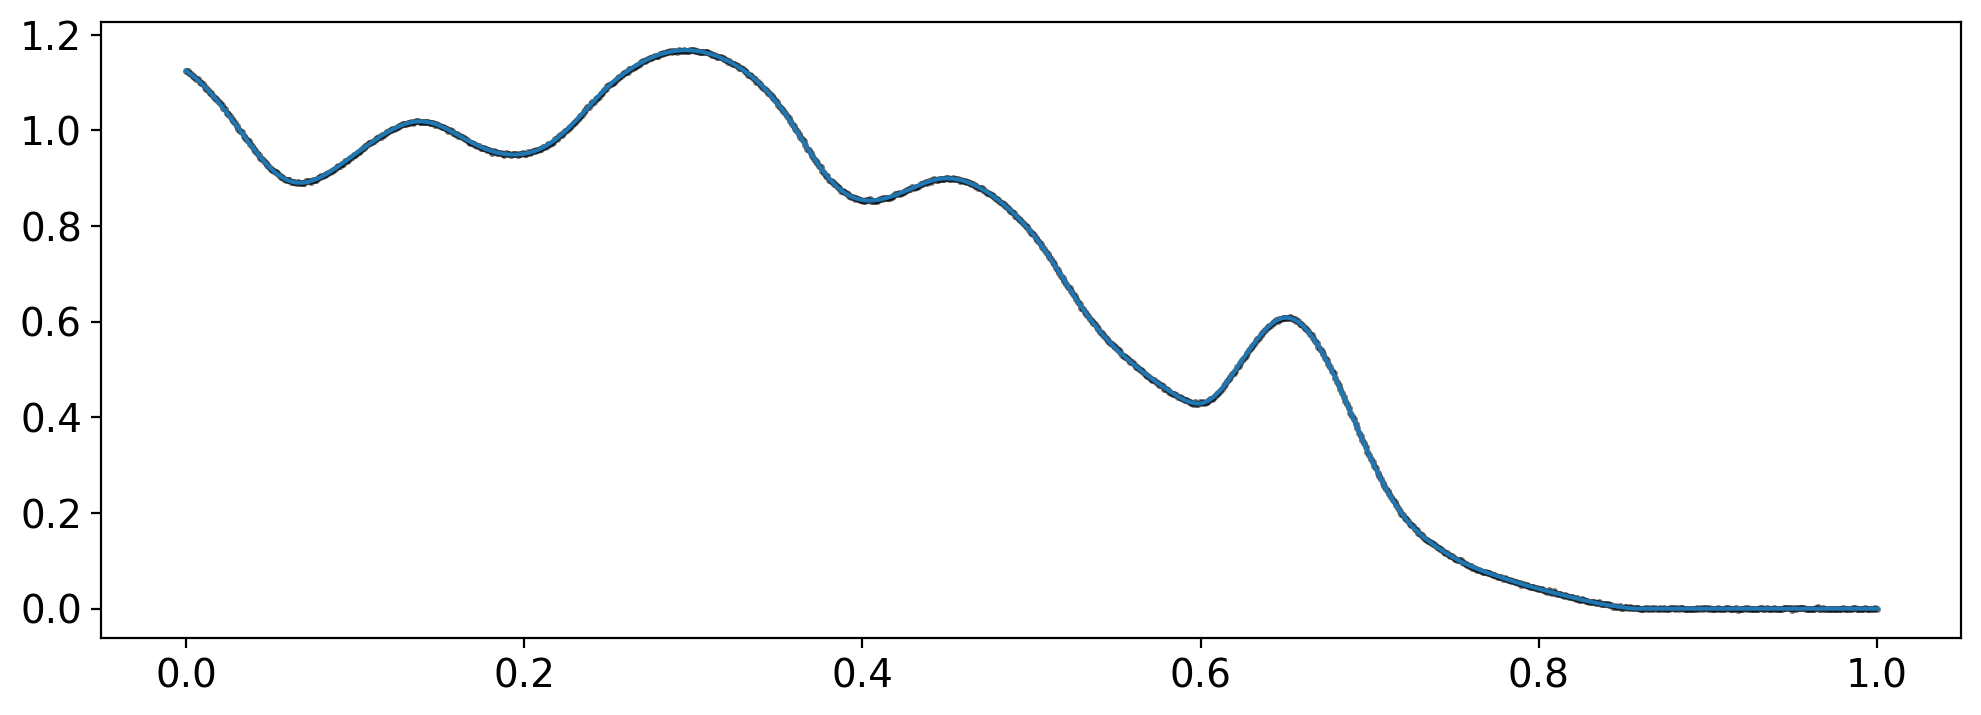

In [165]:
# Generate a synthetic dataset
time = np.linspace(0, 1, 1000)
kwargs=dict(
    theta=360/0.33 * time,
    xo=np.linspace(-32, -28, len(time)),
    yo=5,
    ro=30.0,
)
flux0 = map.flux(**kwargs)
ferr = 1e-3
flux = flux0 + ferr * np.random.randn(len(time))
map.set_data(flux, C=ferr**2)

# Plot it
plt.plot(time, flux, "k.", ms=3, alpha=0.5)
plt.plot(time, flux0);

Compiling `X`... Done.


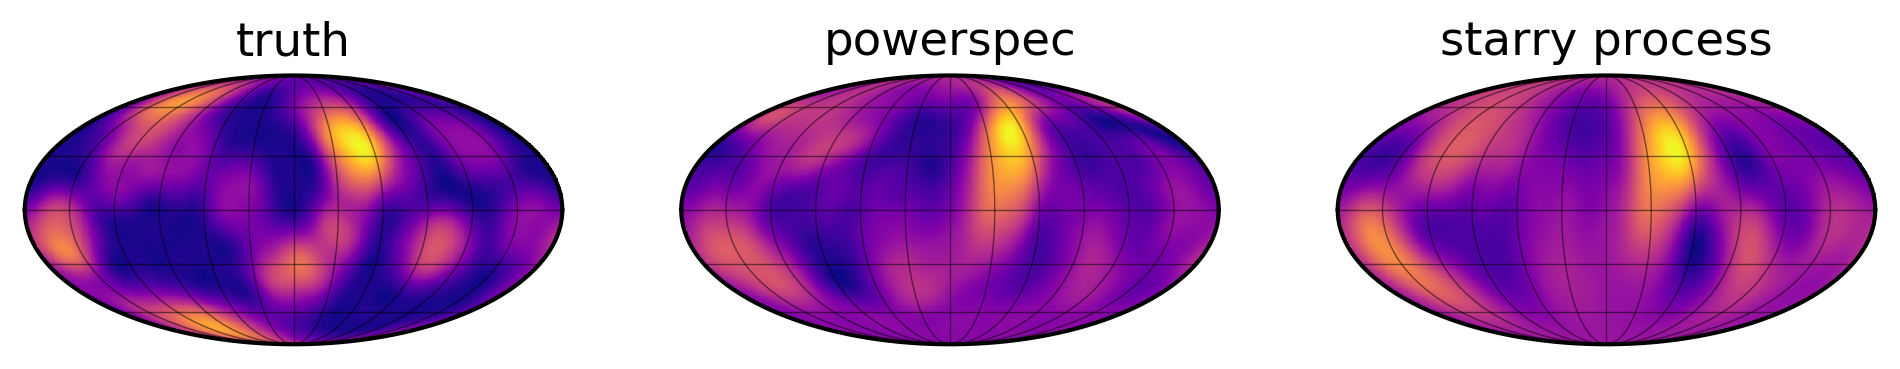

In [166]:
fig, ax = plt.subplots(1, 3)

# Truth
map[1:, :] = y0[1:]
map.show(projection="moll", ax=ax[0])
ax[0].set_title("truth")

# Constant power spectrum prior
map.set_prior(L=1e-5)
y, _ = map.solve(**kwargs)
map[1:, :] = y[1:]
map.show(projection="moll", ax=ax[1])
ax[1].set_title("powerspec")

# Starry process prior
map.set_prior(mu=mu, L=cov)
y, _ = map.solve(**kwargs)
map[1:, :] = y[1:]
map.show(projection="moll", ax=ax[2])
ax[2].set_title("starry process");